## Requirements
* monthly income/expenditure over time
* quarterly income breakdown
* quarterly expenditure breakdown
* descriptions that mention drugs
* machine learning to categorise transactions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [18]:
data = pd.read_csv("administration/CSVData.csv", header=None)
data.columns = ["date", "amount", "description", "balance"]
data['date']  = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.astype({'amount':'float', 'balance':'float'})

date           datetime64[ns]
amount                float64
description            object
balance               float64
dtype: object

In [4]:
# Remove transfers between my own accounts
data = data[~data["description"].str.contains('(?=.*transfer).*(?=.*xx4138)', case=False, regex=True)]
data = data[~data["description"].str.contains('(?=.*transfer).*(?=.*xx9333)', case=False, regex=True)]

credit = data[data.amount > 0]
debit = data[data.amount < 0]

Text(0, 0.5, 'amount ($)')

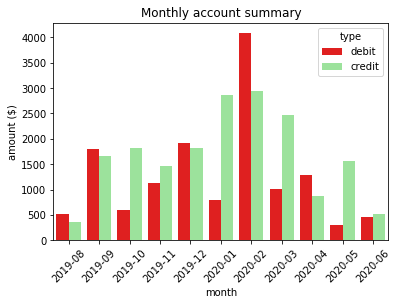

In [33]:
credit.index = pd.to_datetime(credit['date'],format='%d/%m/%Y %I:%M%p')
debit.index = pd.to_datetime(debit['date'],format='%d/%m/%Y %I:%M%p')
monthly_credit = credit.groupby(by=[credit.index.month, credit.index.year]).sum()
monthly_debit = debit.groupby(by=[debit.index.month, debit.index.year]).sum()
monthly_credit.index.names = ['month', 'year']
monthly_debit.index.names = ['month', 'year']
monthly_summary = monthly_credit.join(monthly_debit, on=["month", "year"], lsuffix="_credit")
monthly_summary = monthly_summary.drop(['balance_credit', 'balance'], axis=1)
monthly_summary.columns = ['credit', 'debit']
monthly_summary["net"] = monthly_summary.credit + monthly_summary.debit

monthly_summary.reset_index(level=0, inplace=True)
monthly_summary.reset_index(level=0, inplace=True)
monthly_summary.columns = ['y', 'm', 'credit', 'debit', 'net']

def concat(y, m):
    if len(str(m)) == 1:
        return str(y)+"-0"+str(m) 
    else:
        return str(y)+"-"+str(m)

monthly_summary["month"] = [concat(y, m) for y, m in zip(monthly_summary.y, monthly_summary.m)]

# monthly_summary = monthly_summary.drop(['y', 'm'], axis=1)
monthly_summary = monthly_summary.sort_values('month').reset_index()

monthly_summary = pd.melt(monthly_summary, id_vars=["month"], value_vars=['debit', 'credit'])

my_pal = {'debit':'red', 'credit':'lightgreen'}

monthly_summary.columns = ["month", 'type', 'amount']

monthly_chart = sns.barplot(x="month", y=abs(monthly_summary.amount), hue="type", data=monthly_summary, palette=my_pal)
monthly_chart.set_xticklabels(monthly_chart.get_xticklabels(), rotation=45)
monthly_chart.set_title("Monthly account summary")
monthly_chart.set_ylabel("amount ($)")


In [82]:
total_credit = monthly_summary[monthly_summary.type == 'credit'].amount.sum()

total_debit = monthly_summary[monthly_summary.type == 'debit'].amount.sum()
print( "Total credit:", round(total_credit,2))
print( "Total debit:", round(total_debit,2))
print( "Net position:", round(total_credit + total_debit, 2))

Total credit: 18347.62
Total debit: -13892.73
Net position: 4454.89


Text(0, 0.5, 'amount ($)')

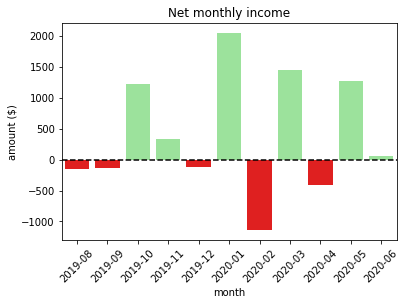

In [79]:

sum_monthly_summary = monthly_summary.groupby('month').sum()
sum_monthly_summary.reset_index(level=0, inplace=True)

pal = {}
for month, amount in zip(sum_monthly_summary.month, sum_monthly_summary.amount):
    if amount>0:
        pal[month] = "lightgreen"
    else:
        pal[month] = "r"

net_monthly_chart = sns.barplot(x="month", y=sum_monthly_summary.amount, data=sum_monthly_summary, palette=pal)
net_monthly_chart.axhline(ls='--', color="k")
net_monthly_chart.set_xticklabels(net_monthly_chart.get_xticklabels(), rotation=45)
net_monthly_chart.set_title("Net monthly income")
net_monthly_chart.set_ylabel("amount ($)")


In [41]:
# isolate potential tutoring entries
tutoring = data[data["amount"]%50==0]
tutoring = tutoring[tutoring["amount"] > 0]
# categorise entries
person = []
i = 0
for row in tutoring.values:
    if "mclean" in row[2].lower():
        person.append("cameron")
    elif "jones" in row[2].lower():
        person.append("ben")
    elif "jorg" in row[2].lower():
        person.append("izzy")
    elif "PADDY" in row[2].upper() or "WALSH" in row[2].upper():
        person.append("paddy")
    elif "hartley" in row[2].lower():
        person.append("brady")
    elif "boddington" in row[2].lower():
        person.append("tyler")
    else:
        person.append("unknown")
    i += 0
    
tutoring["person"] = person

# remove unknowns
tutoring = tutoring[tutoring.person != "unknown"]
tutoring.to_csv("tutoring.csv")

latest_tut = pd.DataFrame(columns=tutoring.columns)

# print(list(latest_check.keys()))
zeros = [0 for i in range(6)]

blanks = pd.DataFrame({"date":[date for i in range(len(latest_check))],
                      "amount":[0 for i in range(6)],
                      "description": ["" for i in range(6)],
                      "balance": [0 for i in range(6)],
                      "person": list(latest_check.keys())})
latest_tut = latest_tut.append(blanks)
latest_tut

In [50]:
    
latest_tut_sum = latest_tut.groupby(['person']).sum().drop({"balance"}, axis=1).reset_index()
latest_tut_sum = latest_tut_sum[['person', 'amount']]
latest_tut_sum.columns = ['person', 'payments']
latest_tut_sum = latest_tut_sum.sort_values(by="person")
latest_tut_sum.payments = latest_tut_sum.payments/50
latest_tut_sum['payable'] = [x for x in owings.values()]

latest_tut_sum = pd.melt(latest_tut_sum, id_vars=["person"], value_vars=['payments', 'payable'])
latest_tut_sum

,person,variable,value
0,ben,payments,0.0
1,brady,payments,0.0
2,cameron,payments,0.0
3,izzy,payments,0.0
4,paddy,payments,0.0
5,tyler,payments,0.0
6,ben,payable,0.0
7,brady,payable,0.0
8,cameron,payable,0.0
9,izzy,payable,1.0


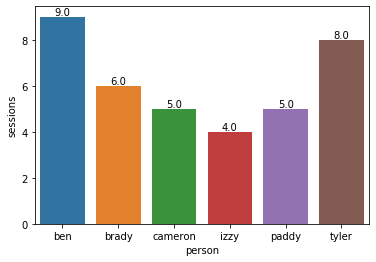

In [9]:



sessions = tutoring.groupby(['person']).sum().drop({"balance"}, axis=1).reset_index()
sessions.columns = ["person", "sessions"]
sessions.sessions = sessions.sessions/50

p = sns.barplot(data=sessions, x="person", y="sessions")

for index, row in sessions.iterrows():
    p.text(row.name, row.sessions + 0.05, round(row.sessions,0), color='black', ha="center")


In [10]:
# Most recent payment dates per person
dates = tutoring.groupby(['person']).max().drop({"balance", "amount", 'description'}, axis=1).to_dict()

dates = dates['date']
print(dates)

{'ben': Timestamp('2020-05-14 00:00:00'), 'brady': Timestamp('2020-03-26 00:00:00'), 'cameron': Timestamp('2020-05-15 00:00:00'), 'izzy': Timestamp('2020-05-09 00:00:00'), 'paddy': Timestamp('2020-05-11 00:00:00'), 'tyler': Timestamp('2020-04-20 00:00:00')}
